In [1]:
!pip install -q pystan nest_asyncio

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, norm
import stan
import nest_asyncio

nest_asyncio.apply()

In [3]:
# Set random seed
np.random.seed(42)

# Parameters
num_series = 1000         # Number of time series
series_length = 135       # Length of each time series
trend_strength = 1 / 100  # Trend strength (1°C/century)
trend_options = [1, -1]   # Possible trends: +1°C/century or -1°C/century

# Generate base time series as random walks
time_series_data = np.cumsum(np.random.normal(loc=0, scale=1, size=(num_series, series_length)), axis=1)

# Randomly select a subset to apply trends
num_trended_series = int(0.5 * num_series)
trended_indices = np.random.choice(num_series, size=num_trended_series, replace=False)

# Apply positive or negative linear trends to the selected series
for idx in trended_indices:
    trend_direction = np.random.choice(trend_options)  # +1 or -1
    linear_trend = trend_strength * np.arange(series_length) * trend_direction
    time_series_data[idx] += linear_trend

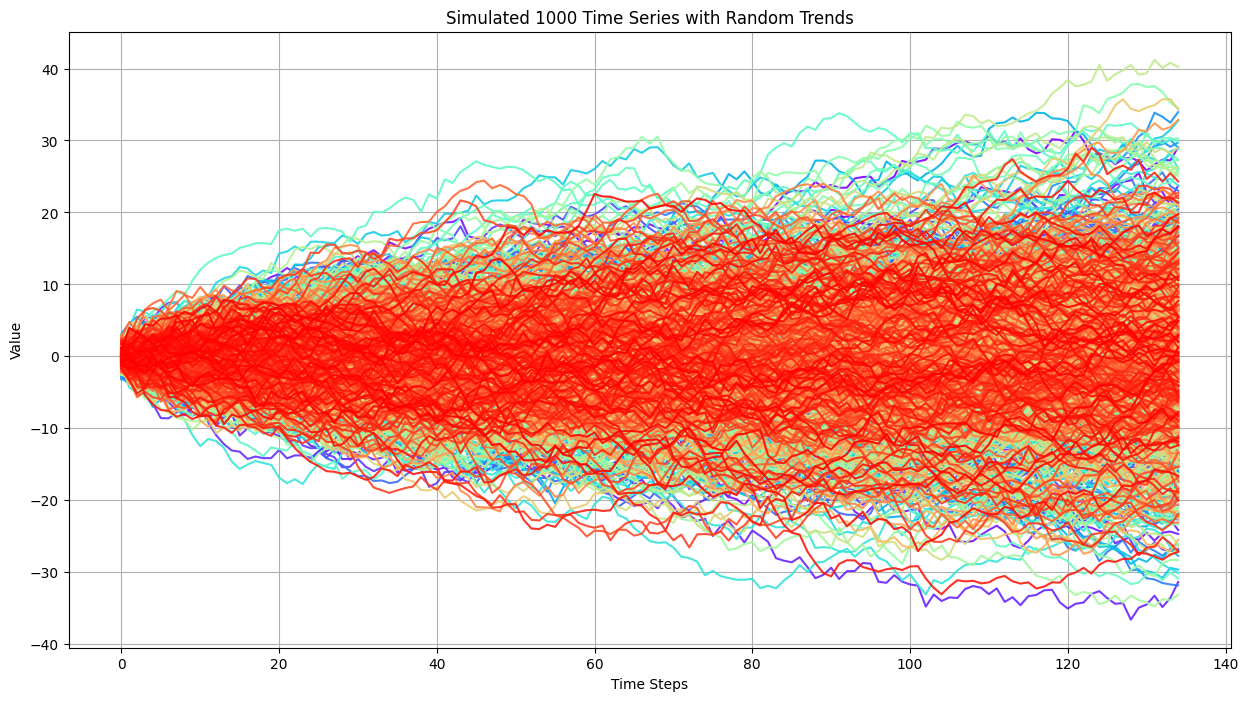

In [4]:
# Plot all time series
plt.figure(figsize=(15, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, num_series))
for i in range(num_series):
    plt.plot(time_series_data[i], alpha=0.9, color=colors[i])
plt.title('Simulated 1000 Time Series with Random Trends')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [5]:
# Compute slopes and standard errors
slopes = []
standard_errors = []

for series in time_series_data:
    regression = linregress(np.arange(series_length), series)
    slopes.append(regression.slope)
    standard_errors.append(regression.stderr)

slopes = np.array(slopes)
standard_errors = np.array(standard_errors)

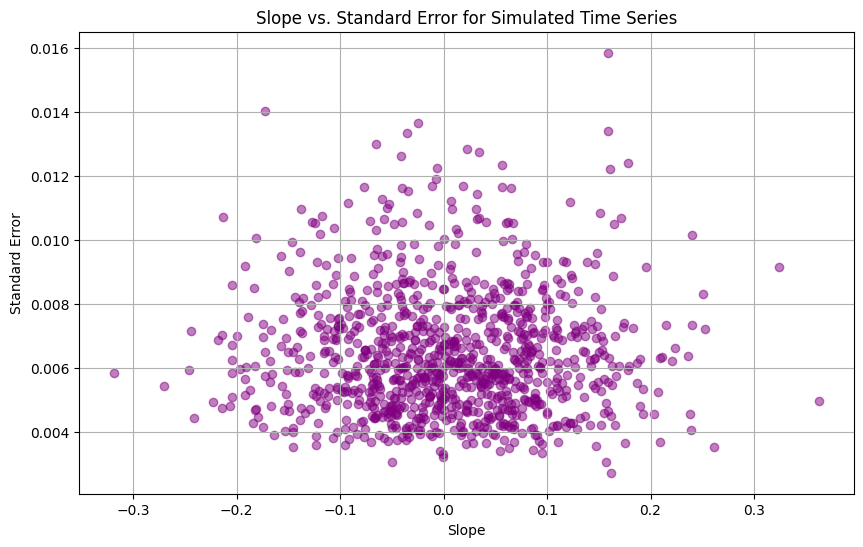

In [6]:
# Scatterplot of slopes vs. standard errors
plt.figure(figsize=(10, 6))
plt.scatter(slopes, standard_errors, alpha=0.5, color='purple')
plt.xlabel('Slope')
plt.ylabel('Standard Error')
plt.title('Slope vs. Standard Error for Simulated Time Series')
plt.grid(True)
plt.show()

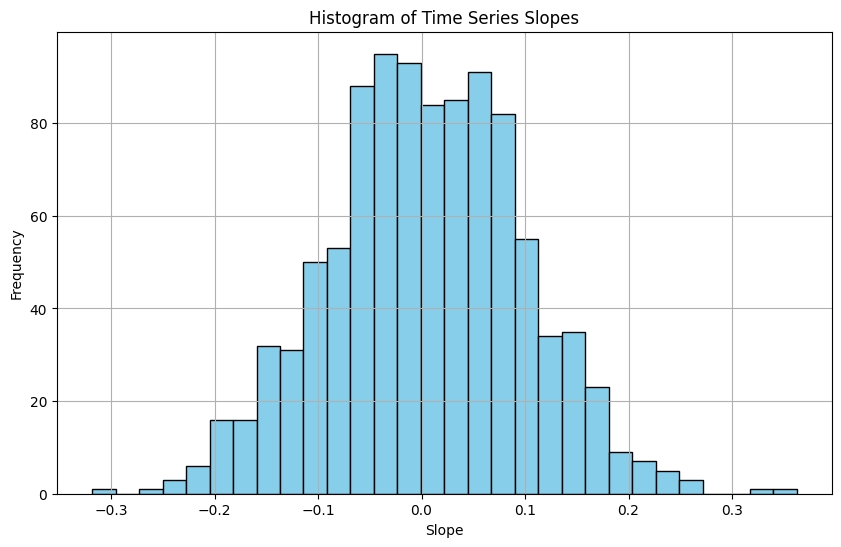

In [7]:
# Histogram of slopes
plt.figure(figsize=(10, 6))
plt.hist(slopes, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Time Series Slopes')
plt.grid(True)
plt.show()

In [8]:
# # Define the Stan Mixture Model
# stan_code = """
# data {
#     int<lower=1> K;
#     int<lower=1> N;
#     array[N] real y;
#     array[K] real mu;
# }
# parameters {
#     simplex[K] theta;
#     real<lower=0> sigma;
# }
# model {
#     array[K] real ps;
#     sigma ~ cauchy(0, 2.5);
#     for (n in 1:N) {
#         for (k in 1:K) {
#             ps[k] = log(theta[k]) + normal_lpdf(y[n] | mu[k], sigma);
#         }
#         target += log_sum_exp(ps);
#     }
# }
# generated quantities {
#     matrix[N, K] p;
#     for (n in 1:N) {
#         array[K] real p_raw;
#         for (k in 1:K) {
#             p_raw[k] = theta[k] * exp(normal_lpdf(y[n] | mu[k], sigma));
#         }
#         for (k in 1:K) {
#             p[n, k] = p_raw[k] / sum(p_raw);
#         }
#     }
# }
# """

In [9]:
# # Define the Stan Mixture Model
# stan_code = """
# data {
#     int<lower=1> K;
#     int<lower=1> N;
#     array[N] real y;
#     array[K] real mu;
# }
# parameters {
#     simplex[K] theta;
#     real<lower=1e-3> sigma;  // Set a stronger lower bound on sigma
# }
# model {
#     array[K] real ps;

#     sigma ~ normal(0, 2);  // Changed prior from cauchy(0, 2.5) to normal(0, 2)

#     for (n in 1:N) {
#         for (k in 1:K) {
#             ps[k] = log(theta[k]) + normal_lpdf(y[n] | mu[k], sigma);
#         }
#         target += log_sum_exp(ps);
#     }
# }
# generated quantities {
#     matrix[N, K] p;
#     for (n in 1:N) {
#         array[K] real p_raw;
#         for (k in 1:K) {
#             p_raw[k] = theta[k] * exp(normal_lpdf(y[n] | mu[k], sigma));
#         }
#         for (k in 1:K) {
#             p[n, k] = p_raw[k] / sum(p_raw);
#         }
#     }
# }
# """

In [10]:
# # Define the Stan Mixture Model
# stan_code = """
# data {
#     int<lower=1> K;
#     int<lower=1> N;
#     array[N] real y;
#     array[K] real mu;
# }
# parameters {
#     simplex[K] theta;
#     real<lower=1e-3> sigma;
# }
# model {
#     array[K] real ps;

#     // Assign a Dirichlet prior to theta
#     theta ~ dirichlet(rep_vector(1.0, K));  // Uniform prior over the simplex

#     sigma ~ normal(0, 2);

#     for (n in 1:N) {
#         for (k in 1:K) {
#             ps[k] = log(theta[k]) + normal_lpdf(y[n] | mu[k], sigma);
#         }
#         target += log_sum_exp(ps);
#     }
# }
# generated quantities {
#     matrix[N, K] p;
#     for (n in 1:N) {
#         array[K] real p_raw;
#         for (k in 1:K) {
#             p_raw[k] = theta[k] * exp(normal_lpdf(y[n] | mu[k], sigma));
#         }
#         for (k in 1:K) {
#             p[n, k] = p_raw[k] / sum(p_raw);
#         }
#     }
# }
# """

In [11]:
# # Define the Stan Mixture Model
# stan_code = """
# data {
#     int<lower=1> K;
#     int<lower=1> N;
#     array[N] real y;
# }
# parameters {
#     simplex[K] theta;
#     array[K] real mu;
#     array[K] real<lower=1e-3> sigma;  // Array declaration
# }
# model {
#     theta ~ dirichlet(rep_vector(2.0, K));  // Informative prior
#     mu ~ normal(0, 1);                      // Prior for component means
#     sigma ~ exponential(1);                 // Prior for component-specific sigma

#     for (n in 1:N) {
#         array[K] real ps;
#         for (k in 1:K) {
#             ps[k] = log(theta[k]) + normal_lpdf(y[n] | mu[k], sigma[k]);
#         }
#         target += log_sum_exp(ps);
#     }
# }
# generated quantities {
#     matrix[N, K] p;
#     for (n in 1:N) {
#         array[K] real log_p_raw;
#         for (k in 1:K) {
#             log_p_raw[k] = log(theta[k]) + normal_lpdf(y[n] | mu[k], sigma[k]);
#         }
#         for (k in 1:K) {
#             p[n, k] = exp(log_p_raw[k] - log_sum_exp(log_p_raw));  // Stable computation
#         }
#     }
# }
# """

In [12]:
# Define the Stan Mixture Model
stan_code = """
data {
    int<lower=1> K;
    int<lower=1> N;
    array[N] real y;
    array[K] real mu_prior_mean;  // Prior mean for mu
    real<lower=0> mu_prior_sd;    // Prior standard deviation for mu
}
parameters {
    simplex[K] theta;
    array[K] real mu;
    array[K] real<lower=1e-3> sigma;
}
model {
    theta ~ dirichlet(rep_vector(5.0, K));    // Stronger prior on mixing weights
    mu ~ normal(mu_prior_mean, mu_prior_sd);  // Prior passed from Python
    sigma ~ normal(0, 1);                     // Flexible prior for component variance

    for (n in 1:N) {
        array[K] real ps;
        for (k in 1:K) {
            ps[k] = log(theta[k]) + normal_lpdf(y[n] | mu[k], sigma[k]);
        }
        target += log_sum_exp(ps);
    }
}
generated quantities {
    matrix[N, K] p;
    for (n in 1:N) {
        array[K] real log_p_raw;
        for (k in 1:K) {
            log_p_raw[k] = log(theta[k]) + normal_lpdf(y[n] | mu[k], sigma[k]);
        }
        for (k in 1:K) {
            p[n, k] = exp(log_p_raw[k] - log_sum_exp(log_p_raw));  // Stable computation
        }
    }
}
"""

In [13]:
# Prepare the data and fit the model
K = 2
mu_prior_mean = [-0.05, 0.05]  # Prior mean for each component
mu_prior_sd = 0.01             # Shared standard deviation

stan_data = {
    'K': K,
    'N': len(slopes),
    'y': slopes,
    'mu_prior_mean': mu_prior_mean,
    'mu_prior_sd': mu_prior_sd
}

# Compile and fit the Stan model
posterior = stan.build(stan_code, data=stan_data, random_seed=42)
fit = posterior.sample(num_chains=4, num_samples=2000)
df_fit = fit.to_frame()
print("\n")
display(df_fit.head())

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1701/12000)
Sampling:  15% (1801/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  22% (2600/12000)
Sampling:  23% (2800/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400/12000)
Sampling:  29% (3500/12000)
Sampling:  30% (3600/12000

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1,theta.2,mu.1,...,p.991.2,p.992.2,p.993.2,p.994.2,p.995.2,p.996.2,p.997.2,p.998.2,p.999.2,p.1000.2
draws,,,,,,,,,,,,,,,,,,,,,
0,929.076377,0.976292,0.292685,4.0,31.0,0.0,-927.223814,0.334688,0.665312,-0.056987,...,0.941411,0.896726,0.360782,0.776544,0.457089,0.688909,0.944518,0.544174,0.568036,0.910512
1,929.010446,0.903084,0.307376,3.0,15.0,0.0,-928.044899,0.438816,0.561184,-0.040089,...,0.866853,0.795108,0.288749,0.643615,0.359623,0.554122,0.872375,0.427621,0.447139,0.815935
2,927.369301,0.994012,0.276285,4.0,19.0,0.0,-923.370015,0.601231,0.398769,-0.037136,...,0.740963,0.651351,0.148919,0.483235,0.209459,0.392023,0.748303,0.270817,0.288940,0.676433
3,928.240657,0.899628,0.262776,4.0,31.0,0.0,-924.501098,0.606105,0.393895,-0.033824,...,0.732424,0.631168,0.148330,0.453637,0.200229,0.364730,0.740867,0.253839,0.269958,0.659116
4,929.520191,0.987725,0.292685,3.0,7.0,0.0,-926.663010,0.340702,0.659298,-0.057796,...,0.932960,0.890017,0.353557,0.777164,0.458088,0.693443,0.936024,0.549181,0.573559,0.903104


In [14]:
# List columns in df_fit
print("First 20 columns in df_fit:")
print(list(df_fit.columns[:20]))
print("\nLast 20 columns in df_fit:")
print(list(df_fit.columns[-20:]))

First 20 columns in df_fit:
['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__', 'theta.1', 'theta.2', 'mu.1', 'mu.2', 'sigma.1', 'sigma.2', 'p.1.1', 'p.2.1', 'p.3.1', 'p.4.1', 'p.5.1', 'p.6.1', 'p.7.1']

Last 20 columns in df_fit:
['p.981.2', 'p.982.2', 'p.983.2', 'p.984.2', 'p.985.2', 'p.986.2', 'p.987.2', 'p.988.2', 'p.989.2', 'p.990.2', 'p.991.2', 'p.992.2', 'p.993.2', 'p.994.2', 'p.995.2', 'p.996.2', 'p.997.2', 'p.998.2', 'p.999.2', 'p.1000.2']


In [15]:
# Extract posterior probabilities
posterior_samples = df_fit
posterior_probabilities = posterior_samples.filter(like='p.').values.reshape(-1, num_series, K)
mean_posterior_probs = posterior_probabilities.mean(axis=0)

In [16]:
# Best guess for each series
best_guess = np.argmax(mean_posterior_probs, axis=1) + 1
best_guess_counts = pd.Series(best_guess).value_counts().sort_index()

print("Best guess for each series (component assignment counts):")
print(best_guess_counts)

Best guess for each series (component assignment counts):
1    500
2    500
Name: count, dtype: int64


In [17]:
# Expected number correct and standard deviation
max_probs = np.max(mean_posterior_probs, axis=1)
expected_correct = np.sum(max_probs)
sd_correct = np.sqrt(np.sum(max_probs * (1 - max_probs)))

print(f"Expected number correct: {expected_correct:.1f}")
print(f"Standard deviation: {sd_correct:.1f}")

Expected number correct: 637.0
Standard deviation: 14.0


In [18]:
# Probability of getting at least 900 correct
prob_at_least_900 = 1 - norm.cdf(899.5, loc=expected_correct, scale=sd_correct)
print(f"Probability of getting at least 900 correct: {prob_at_least_900:.8e}")

# Inverse of the probability
inverse_probability = 1 / prob_at_least_900 if prob_at_least_900 != 0 else np.inf
print(f"Inverse of the probability: {inverse_probability:.1f}")

Probability of getting at least 900 correct: 0.00000000e+00
Inverse of the probability: inf
